In [2]:
import platform
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from scipy import ndimage
from skimage.segmentation import active_contour
from skimage.draw import polygon
from IPython.display import clear_output
from time import sleep, time
from copy import deepcopy
from sklearn.cluster import KMeans

<h4>Loading Video</h4>

In [3]:
def load_video(vidFile):
    '''
    Reads the video
    :param vidFile: Video file
    :return: video sequence, frame rate, width & height of video frames
    '''
    print('Load video')
    vid = cv2.VideoCapture(vidFile)
    fr = vid.get(cv2.CAP_PROP_FPS)  # frame rate
    len = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    vidWidth = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    vidHeight = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # save video as stack of images
    video_stack = np.empty((len, vidHeight, vidWidth, 3))

    for x in range(len):
        ret, frame = vid.read()

        video_stack[x] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        filename = "./data/Images/" + vidFile[7:-4] + "_" + str(x) + ".jpg"
        cv2.imwrite(filename, frame)

    vid.release()

    return video_stack, fr, vidWidth, vidHeight

def save_video(fr, video, output_file) : 
    # Define the video codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can also use other codecs such as 'XVID', 'MJPG', 'DIVX', etc.
    output_video = cv2.VideoWriter(output_file, fourcc, fr, (video[0].shape[1], video[0].shape[0]))  # Adjust FPS as needed (e.g., 25 FPS)

    # Write cropped_video to the video
    for frame in video:
        output_video.write(cv2.cvtColor(np.uint8(frame), cv2.COLOR_RGB2BGR))

    # Release the video writer
    output_video.release()

    print("Video saved successfully.")

def display(frames_list) :
    
    ln = len(frames_list)
    nb_frames = len(frames_list[0])
    print(ln, nb_frames)

    for i in range(nb_frames) : 
        
        fig, axs = plt.subplots(1, ln)
        
        for j in range(ln) :
            if frames_list[j][i].max()>1 : 
                axs[j].imshow(frames_list[j][i].astype(int)) 
            else : 
                axs[j].imshow(frames_list[j][i]) 
                
        plt.show()
        # sleep(0.001)
        clear_output(wait=True)

In [5]:
video_stack, fr, vidWidth, vidHeight = load_video("./data/video_trimed.mp4")
video_stack.shape

Load video


(177, 1024, 576, 3)

<h4>Background Substraction with actif contours method</h4>

In [4]:
def apply_mog(video) :
    
    fgbg = cv2.createBackgroundSubtractorMOG2()
    masks = []
    i = 0
    while(1):
        frame = video[i]

        fgmask = fgbg.apply(frame)
        masks.append(fgmask)

        if i<len(video)-1 :     
            i += 1
        else : 
            break
        
    return masks 

def motion_difference_masks(video) :
    
    diff_masks = []

    for i in range(len(video)-1) :
        
        diff_masks.append(np.uint8(255*(np.sum(np.abs(video[i]-video[i+1]), axis=2)>20)))
        
    diff_masks.append(diff_masks[-1])
    return diff_masks

def filter_masks(masks, kernel_size=4) :
    height, width = masks[0].shape
    num_frames = len(masks)
    filtered_masks = np.zeros((num_frames, height, width), dtype=np.uint8)
    
    for i in range(len(masks)) : 
        filtered_masks[i] = signal.convolve2d(filtered_masks[i], np.ones((10, 10)), mode='same')
        filtered_masks[i] = (filtered_masks[i]>0.5).astype(int)

    # Iterate over each pixel position
    for i in range(height):
        for j in range(width):
            # Extract pixel values across all frames
            pixel_values = masks[:, i, j]

            filtered_masks[:, i, j] = ndimage.median_filter(pixel_values, size=kernel_size)

    return filtered_masks

def fit_active_contour(masks) : 
    
    
    s = np.linspace(0, 2*np.pi, 1000)
    r = 400 + 800*np.sin(s)
    c = 300 + 800*np.cos(s)
    init = np.array([r, c]).T
    
    contours = []
    for i in range(len(masks)) :
        if not (i%1) : 
            start_tm = time()
            snake = active_contour(gaussian(masks[i], 5, preserve_range=False),
                                init, alpha=0.03, beta=1, gamma=0.001)
            contours.append(snake)
            # init = deepcopy(snake)
            print(i, 'Execution time : ', time()-start_tm) 
        else : 
            contours.append(contours[-1])
    return contours

def crop_video(video, contours) : 
    
    croped_video = []
    
    for i in range(len(video)) : 
        img = video[i].astype(int)
        # poly = np.roll(snake, 1, axis=1).astype(int).reshape(-1, 1, 2) 
        poly = contours[i].astype(int)

        rr, cc = polygon(poly[:, 0], poly[:, 1], img.shape)

        masked_img = np.zeros(img.shape)
        for i in range(3) : 
            masked_img[rr, cc, i] = img[rr, cc, i]
            
        croped_video.append(masked_img)
        
    return croped_video

In [6]:
def preprocess(video) : 
    
    # Compute the motion masks 
    diff_masks = motion_difference_masks(video)
    
    # Fit actif contours in each frames's mask 
    contours = fit_active_contour(diff_masks)    # This step can be optmized by fitting the countours 1/2 frames if motion not so fast 
    
    # Crop the video according to the found masks 
    cropped_video = crop_video(video, contours)
    
    return cropped_video, contours, diff_masks


In [7]:
cropped_video, contours, diff_masks = croped_video = preprocess(video_stack[:20])

0 Execution time :  19.348071336746216
1 Execution time :  26.485066413879395
2 Execution time :  18.127557277679443
3 Execution time :  22.421743631362915
4 Execution time :  25.329206228256226
5 Execution time :  23.92934012413025
6 Execution time :  27.976886749267578
7 Execution time :  19.649548768997192
8 Execution time :  21.892972469329834
9 Execution time :  25.287412881851196
10 Execution time :  25.951472282409668
11 Execution time :  21.590026378631592
12 Execution time :  19.85054898262024
13 Execution time :  22.00890326499939
14 Execution time :  18.552786588668823
15 Execution time :  19.9222629070282
16 Execution time :  21.605091333389282
17 Execution time :  29.151562929153442
18 Execution time :  20.509280681610107
19 Execution time :  20.53933620452881


In [8]:
save_video(fr, cropped_video, 'active_cont.mp4')

Video saved successfully.


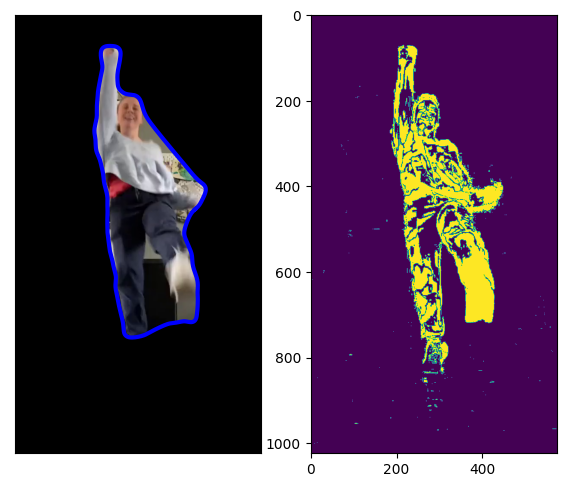

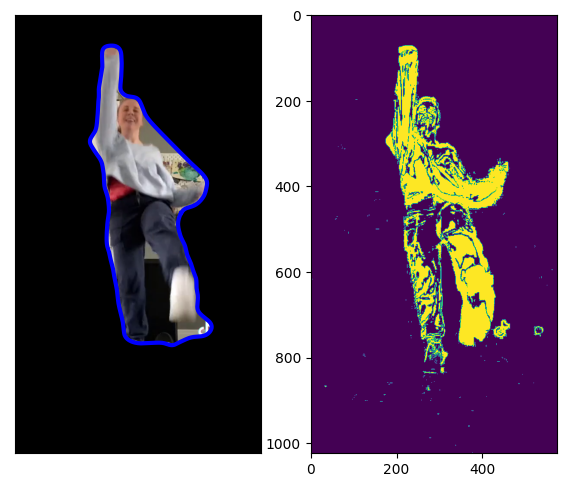

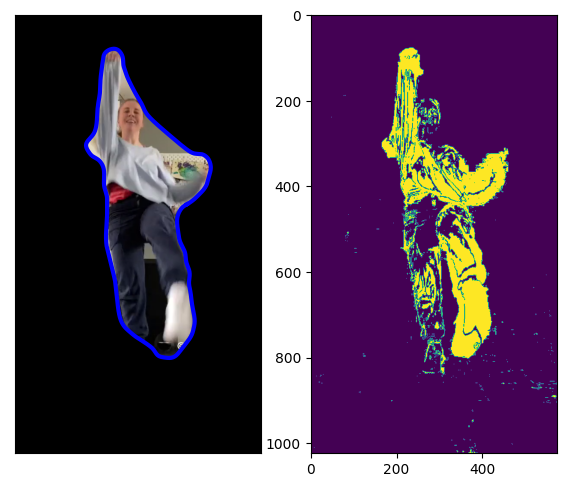

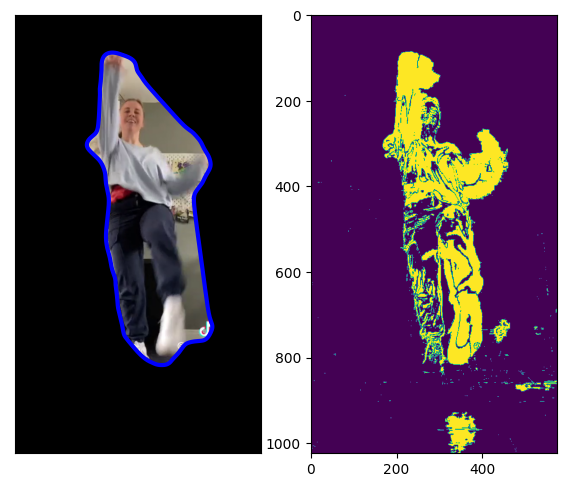

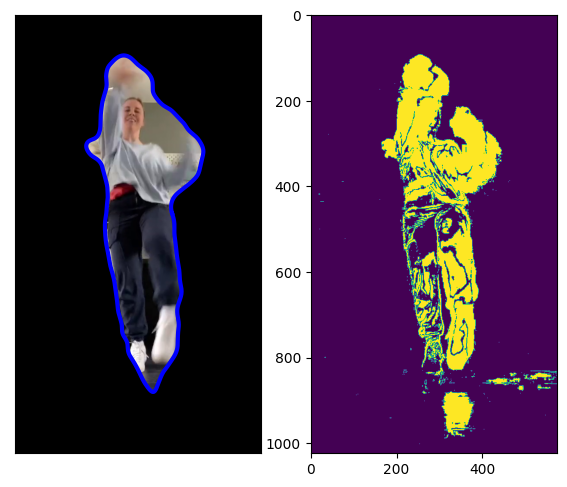

In [9]:
for i in range(5) : 
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(cropped_video[i].astype(int))
    # ax.imshow(cropped_video[i], cmap=plt.cm.gray)
    ax[0].plot(contours[i][:, 1], contours[i][:, 0], '-b', lw=3)
    ax[0].set_xticks([]), ax[0].set_yticks([])
    ax[0].axis([0, cropped_video[i].shape[1], cropped_video[i].shape[0], 0])
    
    ax[1].imshow(diff_masks[i])
    # ax[2].imshow(filtered_masks[:2][i])

    plt.show()

<h3>Methode 2 : using superpixels (worse quality but fast)</h3>

In [ ]:
masks = []

for id in range(len(video_stack)-1) : 

    v1 = cv2.resize(video_stack[id], (video_stack[id].shape[1]//2, video_stack[id].shape[0]//2))
    v2 = cv2.resize(video_stack[id+1], (video_stack[id].shape[1]//2, video_stack[id].shape[0]//2))
    im = np.linalg.norm(v2-v1, axis=2)
    im /= im.max()
    im = im>0.03

    im_f = deepcopy(im)
    # im_f = gaussian(im, 1)

    im_f = signal.convolve2d(im, np.ones((20, 20)), mode='same')
    im_f /= im_f.max()

    lab_im = cv2.cvtColor(np.uint8(v1), cv2.COLOR_BGR2RGB)/255

    sp2 = time()

    cont_img = np.concatenate((2*lab_im, 0.1*im_f.reshape(lab_im.shape[0], lab_im.shape[1], 1)), axis=2)

    sp22 = time()
    # print('Execution time : ', sp22-sp2)

    segments = slic(cont_img, n_segments=100, compactness=0.2)

    sp3 = time()
    # print('Execution time : ', sp3-sp22)

    histograms = []

    for i in np.unique(segments) :
        histograms.append([np.sum(im_f[segments==i]<0.01), np.sum(im_f[segments==i]>0.01)])
        # histograms.append(np.histogram(im_f[segments==i], bins=4)[0])
    
    histograms = np.array(histograms)
    histograms = histograms/np.max(histograms)

    kmeans2 = KMeans(n_clusters=2).fit(histograms)
    labs2 = kmeans2.labels_ 

    final_image = deepcopy(segments)
    for i in np.unique(segments) :
        final_image[segments==i] = labs2[i-1] 
        
    count = [np.sum(im_f[final_image==0]>0.5), np.sum(im_f[final_image==1]>0.5)]
        
    idf_mask = im_f + (final_image==np.argmax(count))
    idf_mask[idf_mask>1] = 1

    idf_mask = signal.convolve2d(idf_mask, np.ones((20, 20)), mode='same')
    idf_mask = gaussian(idf_mask, 1)
    idf_mask /= idf_mask.max()
        
    
    
    masks.append(idf_mask)    
    print(f'frame {id} processed')
    clear_output(wait=True)

frame 175 processed


In [ ]:
croped_video = []
id = 0
for msk in masks : 
    v1 = cv2.resize(video_stack[id], (video_stack[id].shape[1]//2, video_stack[id].shape[0]//2))
    for i in range(3) :
        v1[:, :, i] *= msk
    croped_video.append(v1)
    id += 1 